In [1]:
import yaml
import matplotlib.pyplot as plt
import math
import copy
import derivate_complete as dc

In [2]:
with open("txt files/Wgamma.txt", "r") as f:
    Wgamma = yaml.load(f, Loader=yaml.SafeLoader)
with open("txt files/Zgamma.txt", "r") as f:
    Zgamma = yaml.load(f, Loader=yaml.SafeLoader)
with open("txt files/Znunugamma.txt", "r") as f:
    Znunugamma = yaml.load(f, Loader=yaml.SafeLoader)
with open("txt files/gammajets.txt", "r") as f:
    gammajets = yaml.load(f, Loader=yaml.SafeLoader)
with open("txt files/Wjets.txt", "r") as f:
    Wjets = yaml.load(f, Loader=yaml.SafeLoader)
with open("txt files/Zjets.txt", "r") as f:
    Zjets = yaml.load(f, Loader=yaml.SafeLoader)
with open("txt files/data.txt", "r") as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)
    
signal = {'Wgamma': Wgamma,
          'Zgamma': Zgamma,
          'Znunugamma': Znunugamma,
          'gammajets': gammajets}

background = {'Wjets': Wjets,
              'Zjets': Zjets}

In [3]:
CR = ['SR', 'onemuCR', 'twomuCR', 'twoeCR']
CR_label = ['SR', '1muCR', '2muCR', '2eCR']
met_regions = ['ISR1', 'ISR2', 'ISR3', 'ESR1', 'ESR2']


not_tight_selections = ['tight3', 'tight4', 'tight5']
not_tight = 'tight4'


def merge(sample, key, tightness, Na_Nb):
# first argument: dictionary
# all other arguments: string
 
    return_array = [0 for _ in range(5)]
    
    if key == 'Wgamma' or key == 'Wjets':
        selected_regions = ['SR', 'onemuCR']
    
    if key == 'Zgamma' or key == 'Zjets':
        selected_regions = ['SR', 'twomuCR', 'twoeCR']
    
    if key == 'Znunugamma':
        selected_regions = ['SR']
    
    if key == 'gammajets':
        #return [ sample[key]['gammajetCR'][tightness][Na_Nb] ]
        selected_regions = ['SR']

    for cr in selected_regions:
        return_array = [ return_array[i] + sample[key][cr][met_regions[i]][tightness][Na_Nb] for i in range(5) ]
    
    return return_array + [ sample[key]['gammajetCR'][tightness][Na_Nb] ]
        
        
def leakage_coefficient(num, den):
    
    ci    = [ 0 for _ in range(len(num)) ]
    sigma = [ 0 for _ in range(len(num)) ]
    
    for i in range(len(ci)):
        
        if num[i] > 0 and den[i] > 0:
            
            ci[i]    = num[i]/den[i]
            sigma[i] = ci[i] * math.sqrt((1/num[i]) + (1/den[i]))
    
    return {'mean': ci, 'sigma': sigma}

def correlation_factor(Na, Nb, Ma, Mb):
   
    R     = [ 0 for _ in range(len(Na)) ]
    sigma = [ 0 for _ in range(len(Na)) ]
    
    for i in range(len(R)):
        
        if Na[i]>0 and Nb[i]>0 and Ma[i]>0 and Mb[i]>0:
            
            R[i]     = (Na[i]*Mb[i])/(Nb[i]*Ma[i])
            sigma[i] = R[i] * math.sqrt((1/Na[i]) + (1/Nb[i]) + (1/Ma[i]) + (1/Mb[i]))
            
            
    return {'mean': R, 'sigma': sigma}

def plot_coefficient(coeff, title):
    
    color = ['r', 'b', 'g', 'orangered']
    linestyle = ''
    j = 0
    
    plt.figure(num=None, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')
        
    
    for key in coeff:
        
        if title != 'R':            
            linestyle = '-'
        
        if key != 'gammajets':
            plt.errorbar([ i-0.04 + j*0.04 for i in range(len(coeff[key]['mean'])) ], coeff[key]['mean'], yerr=coeff[key]['sigma'], fmt=color[j], marker='o', linestyle=linestyle, linewidth=2, label=key)
        
        if key == 'gammajets':
            plt.errorbar([5+j*0.04], coeff[key]['mean'][5], yerr=coeff[key]['sigma'][5], fmt=color[j], marker='o', linestyle=linestyle, linewidth=2, label=key)
        
        j = j + 1
    
    
    plt.xticks(range(6), ["ISR1", "ISR2", "ISR3", "ESR1", "ESR2", "gammajetCR"], fontsize=20)
    
    
    plt.yticks(fontsize=20)
    plt.legend(fontsize="xx-large")
    plt.grid()
    

    plt.ylabel(title + '    ', rotation=0, fontsize=30)
        
        
def analyze_coefficient(coeff):
    
    temp = []
    for key in coeff:
        temp.append(coeff[key])
    
    avarage_array = avarage_mean(temp)
    
    gammajet = {'mean': avarage_array['mean'][5], 'sigma': avarage_array['sigma'][5]}
    
    del avarage_array['mean'][5]
    del avarage_array['sigma'][5]
    
    return {'mean': avarage_array['mean'] + avarage_array['mean'] + avarage_array['mean'] + avarage_array['mean'] + [gammajet['mean']],
            'sigma': avarage_array['sigma'] + avarage_array['sigma'] + avarage_array['sigma'] + avarage_array['mean'] + [gammajet['sigma']]}
    
    
    
    
    
    
def avarage_mean(data):
    
    num = [ 0 for _ in range(len(data[0]['mean'])) ]
    den = [ 0 for _ in range(len(data[0]['mean'])) ]
    
    for i in range(len(data)):
        for j in range(len(data[i]['mean'])):
            
            if data[i]['sigma'][j] > 0:
                num[j] = num[j] + data[i]['mean'][j]/pow(data[i]['sigma'][j],2)
                den[j] = den[j] + 1/pow(data[i]['sigma'][j],2)
            
    mean  = [num[i]/den[i]       for i in range(len(num))]
    sigma = [math.sqrt(1/den[i]) for i in range(len(den))]
    
    return({'mean': mean, 'sigma': sigma})
    

def purity(Na, Nb, Ma, Mb, c1, c2, c3, R):
    
    number_of_regions = len(Na)
    return_dict = {'mean': [0 for _ in range(number_of_regions)], 'sigma': [0 for _ in range(number_of_regions)]}
    
    
    for i in range(number_of_regions):
        
        if Na[i]>0 and Nb[i]>0 and Ma[i]>0 and Mb[i]>0 and c1['mean'][i]>0 and c2['mean'][i]>0 and c3['mean'][i]>0 and R['mean'][i]>0:
            
            x = Mb[i] + Na[i]*c3['mean'][i] - Nb[i]*c2['mean'][i]*R['mean'][i] - Ma[i]*c1['mean'][i]*R['mean'][i]
            y = c1['mean'][i]*c2['mean'][i]*R['mean'][i] - c3['mean'][i]
            z = 4*y*(Na[i]*Mb[i] - Nb[i]*Ma[i]*R['mean'][i])/pow(x,2)

            return_dict['mean'][i] = 100*x*(-1 + math.sqrt(1 + z))/ (2*y*Na[i])
    
            DNa = dc.DNa(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])
            DNb = dc.DNb(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])
            DMa = dc.DMa(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])
            DMb = dc.DMb(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])

            Dc1 = dc.Dc1(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])
            Dc2 = dc.Dc2(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])
            Dc3 = dc.Dc3(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])
            DR  =  dc.DR(Na[i],Nb[i],Ma[i],Mb[i],c1['mean'][i],c2['mean'][i],c3['mean'][i],R['mean'][i])
            
            return_dict['sigma'][i] = 100*math.sqrt( Na[i]*pow(DNa,2) + Nb[i]*pow(DNb,2) + Ma[i]*pow(DMa,2) + Mb[i]*pow(DMb,2) + pow(Dc1*c1['sigma'][i],2) + pow(Dc2*c2['sigma'][i],2) + pow(Dc3*c3['sigma'][i],2) + pow(DR*R['sigma'][i],2) )
            
    return return_dict

In [6]:
purity_estimation = []
for not_tight in not_tight_selections:
    
    
    # calcolo dei coefficienti di leakage e correlazione
    c1 = {}
    c2 = {}
    c3 = {}
    R  = {}

    for key in signal:

        Na = merge(signal, key, 'tight', 'Na')
        Nb = merge(signal, key, 'tight', 'Nb')
        Ma = merge(signal, key, not_tight, 'Na')
        Mb = merge(signal, key, not_tight, 'Nb')

        c1.update({key: leakage_coefficient(Nb,Na)})
        c2.update({key: leakage_coefficient(Ma,Na)})
        c3.update({key: leakage_coefficient(Mb,Na)})


    for key in background:

        Na = merge(background, key, 'tight', 'Na')
        Nb = merge(background, key, 'tight', 'Nb')
        Ma = merge(background, key, not_tight, 'Na')
        Mb = merge(background, key, not_tight, 'Nb')

        R.update({key: correlation_factor(Na,Nb,Ma,Mb)})


    # plot_coefficient(c1, 'c1')
    # plot_coefficient(c2, 'c2')
    # plot_coefficient(c3, 'c3')
    # plot_coefficient(R, 'R')


    # frof 5+1 values for each coefficient we want 21 values, one for each region
    c1 = analyze_coefficient(c1)
    c2 = analyze_coefficient(c2)
    c3 = analyze_coefficient(c3)
    R  = analyze_coefficient(R)


    Na = [data[cr][met_region]['tight']['Na'] for cr in CR for met_region in met_regions] + [data['gammajetCR']['tight']['Na']]
    Nb = [data[cr][met_region]['tight']['Nb'] for cr in CR for met_region in met_regions] + [data['gammajetCR']['tight']['Nb']]
    Ma = [data[cr][met_region][not_tight]['Na'] for cr in CR for met_region in met_regions] + [data['gammajetCR'][not_tight]['Na']]
    Mb = [data[cr][met_region][not_tight]['Nb'] for cr in CR for met_region in met_regions] + [data['gammajetCR'][not_tight]['Nb']]

    purity_estimation.append(purity(Na, Nb, Ma, Mb, c1, c2, c3, R))

Text(0, 0.5, 'P[%]    ')

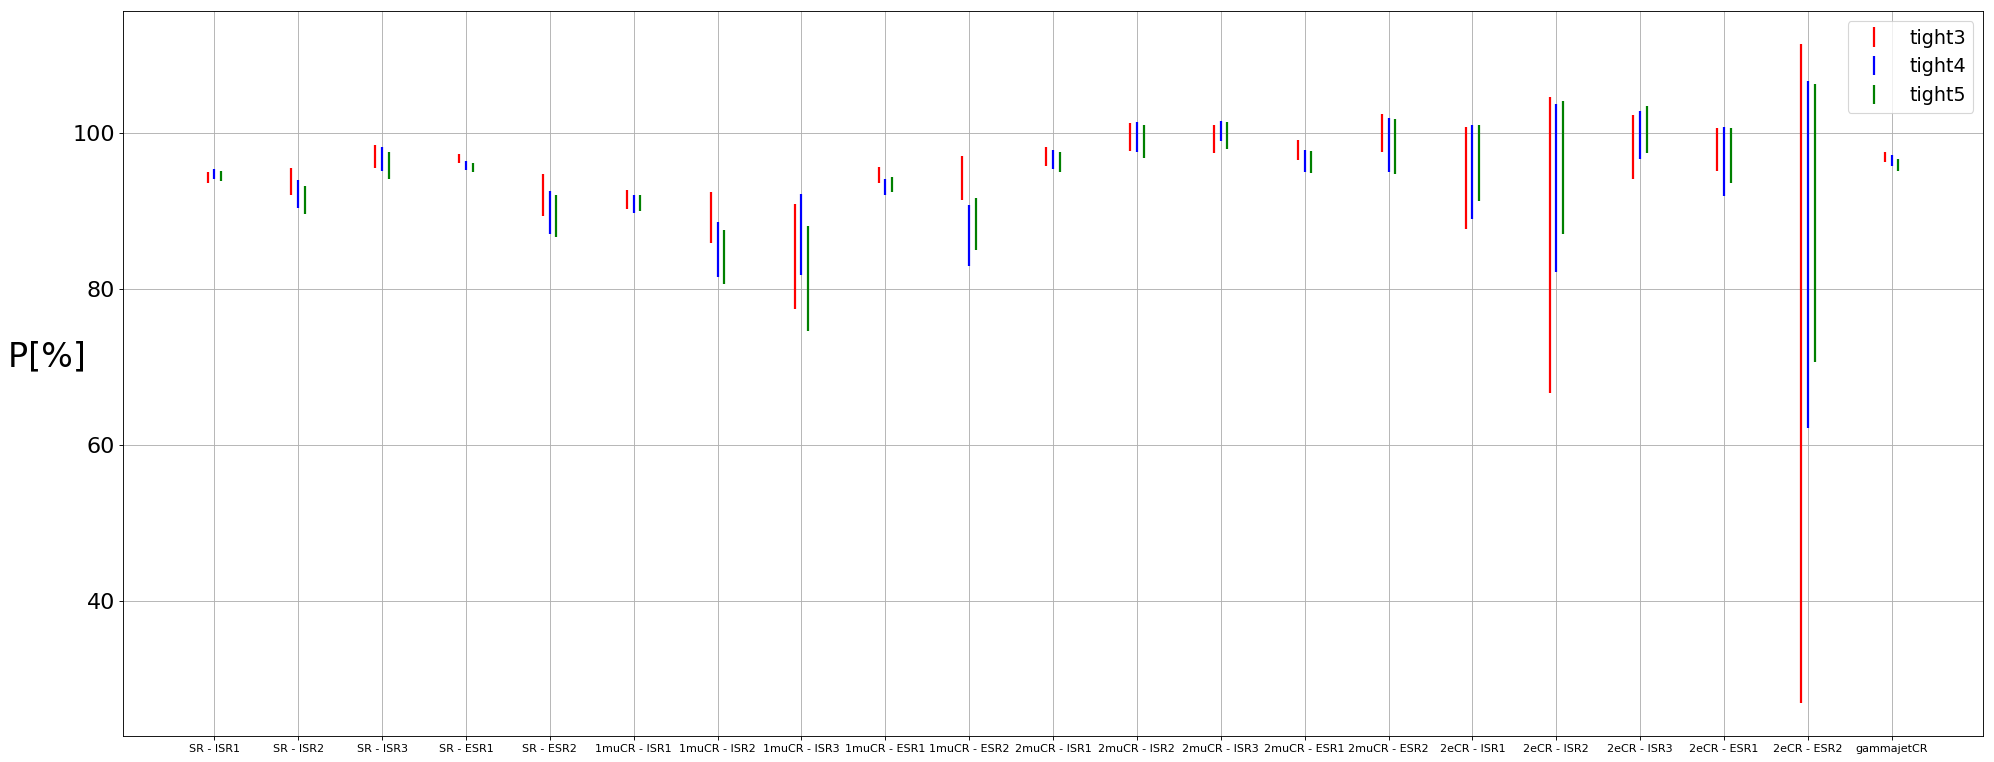

In [11]:
plt.figure(num=None, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')

plt.errorbar([i-0.08 for i in range(21)], purity_estimation[0]['mean'], yerr=purity_estimation[0]['sigma'], fmt='r', marker='', linestyle='', linewidth=2, label=not_tight_selections[0])
plt.errorbar([i+0.00 for i in range(21)], purity_estimation[1]['mean'], yerr=purity_estimation[1]['sigma'], fmt='b', marker='', linestyle='', linewidth=2, label=not_tight_selections[1])
plt.errorbar([i+0.08 for i in range(21)], purity_estimation[2]['mean'], yerr=purity_estimation[2]['sigma'], fmt='g', marker='', linestyle='', linewidth=2, label=not_tight_selections[2])


plt.xticks(range(21), [cr + ' - ' + met_region for cr in CR_label for met_region in met_regions] + ['gammajetCR'])
plt.yticks(fontsize=20)
plt.legend(fontsize="xx-large")
plt.grid()


plt.ylabel('P[%]    ', rotation=0, fontsize=30)